In [529]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import umap
import pickle, pandas as pd
import matplotlib.patches as mpatches
from neo4j import GraphDatabase

In [530]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Meniere19"))
with driver.session(database="system") as s:
        res = s.run("SHOW DATABASES")
    

In [531]:
driver.open(target="newont1")

In [532]:
run_prefix = "att"
datadir = "newont1"
data_name = "ml_svd"
epoch = 1
snap = np.load(f"experiment_logs/{run_prefix}/embeddings/epoch_{epoch:03d}.npz")
node_ids = snap["node_ids"] # [N]
embeddings = snap["embeddings"] # [N, K, D]
K = embeddings.shape[1]

In [533]:
file_path = "../data/processed/newont1/raw/node2id.pkl"
node2id_path = file_path
with open(node2id_path, "rb") as f:
    node2id = pickle.load(f)

In [534]:
id2node = {v: k for k, v in node2id.items()}             # invert
names = pd.Series(node_ids).map(id2node).fillna("UNK")  

In [535]:
names

0     92381
1     92387
2     92390
3     92394
4     92425
5     92427
6     92453
7     92457
8     92467
9     92475
10    92503
11    92510
12    92544
13    92551
14    92562
15    92567
16    92583
17    92594
18    92666
19    92668
20    92673
21    92724
22    92726
23    92730
24    92744
25    92757
26    92766
27    92783
28    92793
29    92808
30    92818
31    92827
32    92834
33    92855
34    92874
35    92886
36    92900
37    92940
38    92962
39    92994
40    93022
41    93024
42    93028
43    93052
44    93060
45    93092
46    93099
47    93100
48    93122
49    93131
50    93138
51    93145
dtype: object

In [515]:
cs_data = []
with driver.session(database="newont1") as session:
    for name in names:
        query = f"match (p) where p.nid = {name} return p as node;"
        for record in session.run(query):
            cs_data.append(record['node'])

In [516]:
cs_data

[<Node element_id='4:a209f65b-d07f-440d-8a5b-ea10739e7d67:105939' labels=frozenset({'Consumer'}) properties={'INCOME_DESC': '100-124K', 'MARITAL_STATUS_CODE': 'A', 'HOMEOWNER_DESC': 'Homeowner', 'KID_CATEGORY_DESC': '3+', 'nid': 92381, 'HOUSEHOLD_SIZE_DESC': '5+', 'AGE_DESC': '35-44', 'hh_key': 77, 'HH_COMP_DESC': '2 Adults Kids'}>,
 <Node element_id='4:a209f65b-d07f-440d-8a5b-ea10739e7d67:105945' labels=frozenset({'Consumer'}) properties={'INCOME_DESC': '35-49K', 'MARITAL_STATUS_CODE': 'U', 'HOMEOWNER_DESC': 'Unknown', 'KID_CATEGORY_DESC': '1', 'nid': 92387, 'HOUSEHOLD_SIZE_DESC': '2', 'AGE_DESC': '35-44', 'hh_key': 98, 'HH_COMP_DESC': '1 Adult Kids'}>,
 <Node element_id='4:a209f65b-d07f-440d-8a5b-ea10739e7d67:105948' labels=frozenset({'Consumer'}) properties={'INCOME_DESC': 'Under 15K', 'MARITAL_STATUS_CODE': 'B', 'HOMEOWNER_DESC': 'Homeowner', 'KID_CATEGORY_DESC': '2', 'nid': 92390, 'HOUSEHOLD_SIZE_DESC': '3', 'AGE_DESC': '25-34', 'hh_key': 105, 'HH_COMP_DESC': '1 Adult Kids'}>,
 <N

In [560]:
end_embeddings = embeddings[:, -3, :]    # shape [Nc, 78]
from sklearn.cluster import  KMeans
model = KMeans(n_clusters=4)
model.fit(end_embeddings)
preds = model.predict(end_embeddings)
preds


array([1, 3, 0, 0, 0, 1, 3, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 3, 0, 0, 0,
       2, 0, 2, 3, 0, 0, 3, 0, 0, 0, 3, 1, 0, 2, 1, 2, 0, 2, 0, 2, 0, 1,
       1, 3, 2, 0, 2, 0, 0, 0], dtype=int32)

/Users/sebastienm/Library/Caches/pypoetry/virtualenvs/soakn-5ZL-bOm9-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


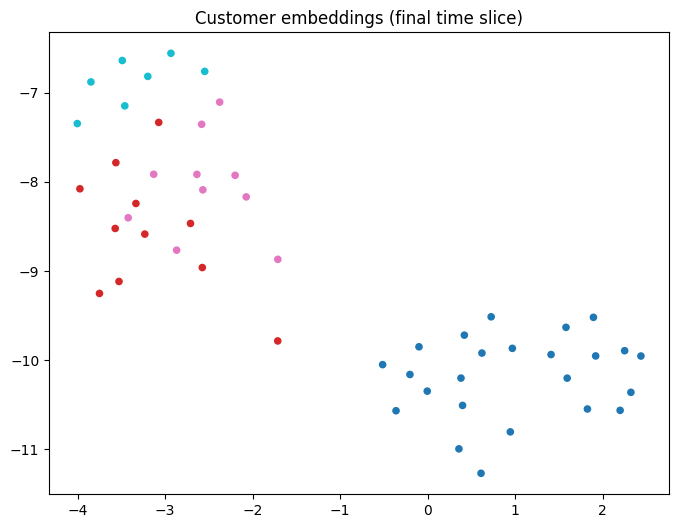

In [561]:
reducer = umap.UMAP(n_neighbors=10, random_state=1)
embedding_2d = reducer.fit_transform(end_embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    cmap="tab10",
    c=preds,
    s=20,
)
plt.title("Customer embeddings (final time slice)")
plt.show()


array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0], dtype=int32)

Time slices (K): 30


/var/folders/xb/pm6jrvrd4z77hx140jh0r1fw0000gn/T/ipykernel_76191/33672768.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=True)


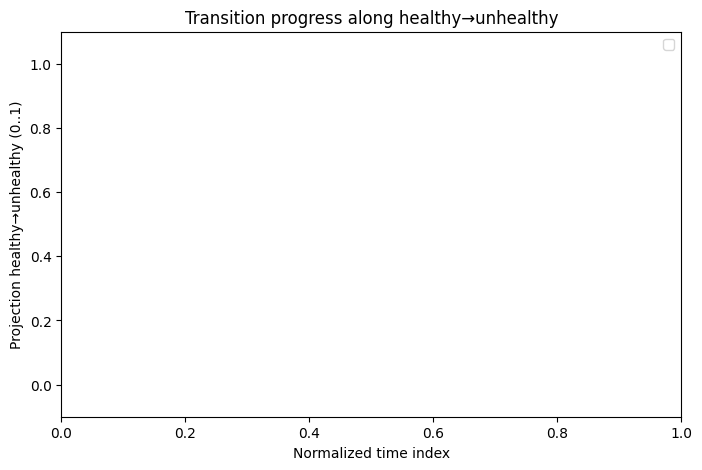

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Config ----
run_prefix = "test"                     # your --prefix for this run
log_root   = Path("experiment_logs/")       # --log_dir base
epoch      = 0                               # which epoch snapshot to use (e.g., 0)
snapshot_npz = log_root / run_prefix / "embeddings" / f"epoch_{epoch:03d}.npz"

K = cust_embeddings.shape[1]
print(f"Time slices (K): {K}")

STATIC = {"healthy_foods", "basic_house_hold", "unhealthy_foods", "student"}
TRANS  = {"trans_quick", "trans_slow"}

# Index by cluster
idx_by_cluster = {c: np.where(cust_clusters.values == c)[0] for c in sorted(set(cust_clusters))}

# Static centroids per slice
static_centroids = {k: {} for k in range(K)}
for lbl in STATIC:
    if lbl not in idx_by_cluster:
        continue
    idx = idx_by_cluster[lbl]
    for k in range(K):
        X = cust_embeddings[idx, k, :]
        if len(X) > 0:
            static_centroids[k][lbl] = X.mean(axis=0)

# Healthy (origin) and Unhealthy (destination) anchors
origin = "healthy_foods"
dest   = "unhealthy_foods"
cA = static_centroids[0][origin]       # start slice centroid of healthy
cB = static_centroids[K-1][dest]       # end slice centroid of unhealthy


def projection_curve(X, cA, cB):
    d = cB - cA
    d_hat = d / (np.linalg.norm(d) + 1e-12)
    proj = np.einsum("nkd,d->nk", X - cA[None, None, :], d_hat)
    max_ref = np.dot(cB - cA, d_hat)
    scale = max_ref if abs(max_ref) > 1e-12 else 1.0
    return proj / scale


time_idx = np.arange(K) / max(K - 1, 1)

plt.figure(figsize=(8, 5))
for tlabel in ["trans_quick", "trans_slow"]:
    if tlabel not in idx_by_cluster:
        continue
    idx = idx_by_cluster[tlabel]
    curves = projection_curve(cust_embeddings[idx, :, :], cA, cB)
    mean_curve = curves.mean(axis=0)
    std_curve = curves.std(axis=0)
    plt.plot(time_idx, mean_curve, label=f"{tlabel} (healthy→unhealthy)")
    plt.fill_between(time_idx, mean_curve - std_curve, mean_curve + std_curve, alpha=0.15)

plt.ylim(-0.1, 1.1)
plt.xlabel("Normalized time index")
plt.ylabel("Projection healthy→unhealthy (0..1)")
plt.title("Transition progress along healthy→unhealthy")
plt.legend(frameon=True)
plt.show()


/Users/sebastienm/Library/Caches/pypoetry/virtualenvs/soakn-5ZL-bOm9-py3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


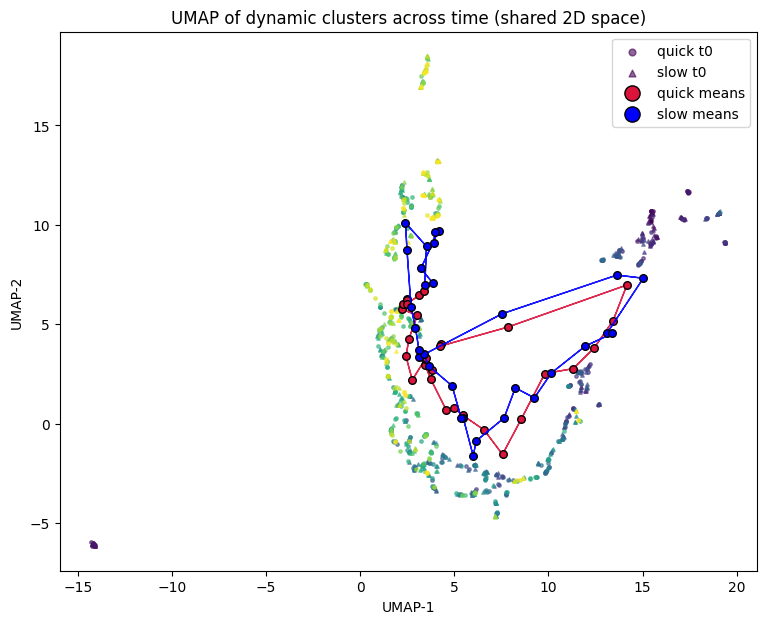

In [104]:
import umap
import matplotlib.pyplot as plt

# Build a single matrix across time for the dynamic clusters
rows, labels_cluster, labels_k = [], [], []
for tlabel in ["trans_quick","trans_slow"]:
    if tlabel not in idx_by_cluster: 
        continue
    idx = idx_by_cluster[tlabel]
    X = cust_emb[idx, :, :]                                      # [n_users, K, D]
    rows.append(X.reshape(-1, D))                                # stack all slices
    labels_cluster += [tlabel] * (X.shape[0]*X.shape[1])
    labels_k      += list(np.tile(np.arange(K), X.shape[0]))

if not rows:
    raise RuntimeError("No dynamic clusters found in snapshot.")
X_all = np.vstack(rows)                                          # [(n_dyn*K), D]
labels_cluster = np.array(labels_cluster)
labels_k = np.array(labels_k)

# Fit UMAP once on all slices
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(X_all)                                # [(n_dyn*K), 2]

# Extract per time slice positions for arrows (cluster means)
def slice_means(cluster_name):
    mask = labels_cluster == cluster_name
    means = []
    for k in range(K):
        mk = mask & (labels_k == k)
        if mk.sum() > 0:
            means.append(X2[mk].mean(axis=0))
        else:
            means.append(np.array([np.nan, np.nan]))
    return np.vstack(means)

M_quick = slice_means("trans_quick")
M_slow  = slice_means("trans_slow")

# Plot: points colored by time slice, shape by cluster
plt.figure(figsize=(9,7))
colors = plt.cm.viridis(np.linspace(0,1,K))
for k in range(K):
    mk_q = (labels_cluster=="trans_quick") & (labels_k==k)
    mk_s = (labels_cluster=="trans_slow") & (labels_k==k)
    plt.scatter(X2[mk_q,0], X2[mk_q,1], c=[colors[k]], s=6, label=f"quick t{k}" if k==0 else None, alpha=0.6, marker='o')
    plt.scatter(X2[mk_s,0], X2[mk_s,1], c=[colors[k]], s=6, label=f"slow t{k}" if k==0 else None, alpha=0.6, marker='^')

# Add mean arrows per cluster
def draw_arrows(M, label, color):
    for a,b in zip(M[:-1], M[1:]):
        if np.all(np.isfinite(a)) and np.all(np.isfinite(b)):
            plt.arrow(a[0], a[1], (b[0]-a[0]), (b[1]-a[1]),
                      head_width=0.02, head_length=0.04, length_includes_head=True, color=color, alpha=0.9)
    plt.scatter(M[:,0], M[:,1], c=[color], s=30, label=f"{label} means", edgecolor='k')

draw_arrows(M_quick, "quick", "crimson")
draw_arrows(M_slow,  "slow",  "blue")

plt.title("UMAP of dynamic clusters across time (shared 2D space)")
plt.legend(frameon=True, markerscale=2)
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.show()


In [79]:
import numpy as np
import pandas as pd

def first_crossing(curve, thr=0.5):
    idx = np.argmax(curve >= thr)
    return np.nan if curve[idx] < thr else time_idx[idx]

def auc(curve):
    return np.trapezoid(curve, x=time_idx)

def mid_slope(curve):
    k = len(curve)
    if k < 3: return np.nan
    i = k//2
    return (curve[min(i+1,k-1)] - curve[max(i-1,0)]) / (time_idx[min(i+1,k-1)] - time_idx[max(i-1,0)])

def summarize_curves(curves):
    return pd.Series({
        "T50_mean": np.nanmean([first_crossing(c) for c in curves]),
        "T50_std":  np.nanstd([first_crossing(c) for c in curves]),
        "AUC_mean": np.mean([auc(c) for c in curves]),
        "AUC_std":  np.std([auc(c) for c in curves]),
        "mid_slope_mean": np.nanmean([mid_slope(c) for c in curves]),
        "mid_slope_std":  np.nanstd([mid_slope(c) for c in curves]),
    })



# Healthy (origin) and Unhealthy (destination) anchors
origin = "healthy_foods"
dest   = "unhealthy_foods"
cA = static_centroids[0][origin]       # start slice centroid of healthy
cB = static_centroids[K-1][dest]       # end slice centroid of unhealthy
curves = projection_curve(cust_emb[idx, :, :], cA, cB)
# Using the earlier origin/destination setup:
# Ensure time grid exists
time_idx = np.linspace(0, 1, K)

stats = {}
for tlabel in ["trans_quick", "trans_slow"]:
    if tlabel not in idx_by_cluster:
        continue
    idx = idx_by_cluster[tlabel]
    cA = static_centroids[0]["healthy_foods"]
    cB = static_centroids[K-1]["unhealthy_foods"]
    curves = projection_curve(cust_emb[idx, :, :], cA, cB)  # [n_users, K]
    stats[tlabel] = summarize_curves(curves)

pd.DataFrame.from_dict(stats, orient="index")


,T50_mean,T50_std,AUC_mean,AUC_std,mid_slope_mean,mid_slope_std
trans_quick,0.058355,0.028321,0.894050,0.029731,0.188236,0.174193
trans_slow,0.064039,0.031542,0.895627,0.036270,0.164264,0.149148


In [80]:
def path_metrics(X):  # X: [K, D]
    steps = X[1:] - X[:-1]
    lengths = np.linalg.norm(steps, axis=1)
    path_len = np.sum(lengths)
    # curvature via mean turning cos angle
    if len(steps) < 2: 
        return path_len, np.nan
    u = steps[:-1] / (np.linalg.norm(steps[:-1],axis=1,keepdims=True)+1e-12)
    v = steps[1:]  / (np.linalg.norm(steps[1:], axis=1,keepdims=True)+1e-12)
    cosang = np.clip((u*v).sum(axis=1), -1, 1)
    mean_turn = np.degrees(np.arccos(cosang)).mean()
    return path_len, mean_turn

rows=[]
for tlabel in ["trans_quick","trans_slow"]:
    if tlabel not in idx_by_cluster: continue
    for user_idx in idx_by_cluster[tlabel]:
        L, turn = path_metrics(cust_emb[user_idx, :, :])
        rows.append({"cluster":tlabel,"path_length":L,"mean_turn_deg":turn})
pd.DataFrame(rows).groupby("cluster").agg(["mean","std"])


path_length           mean_turn_deg          
                   mean       std          mean       std
cluster                                                  
trans_quick   23.295866  2.794843     85.238289  8.938254
trans_slow    22.351118  1.105988     85.710609  8.184101